# Do moves played (too) fast lead to blunders?

I've got a hunch I lose a sizable number of games just by moving too fast. I can be ahead the whole game, but at a critical point I just don't think (don't focus on opponent's threats, don't see basic tactical patterns), make a move after 1 or 2 seconds and it's game over.

To see if the above is true, I have to find the answer to two questions:
- do I often blitz out moves?
- is the evaluation loss for these blitzed out moves different from other moves?

## Import games from Lichess

First import my Blitz games I downloaded from Lichess. I always play 5+0 meaning you've got 5 minutes for all your moves and don't receive extra seconds if you play a move.

In [1]:
import pandas as pd

games = pd.read_csv('games.csv')

At first sight the data looks good. Some fields necessary for a proper analysis are missing though. I've got the `clock_time`, but that's just the remaining time left. I also need the `move_time` to know how long it took to make a move. Also often I'm not interested in the evaluation numbers themselves, but in the change to the evaluation because of the move made. Just taking the difference between the current and previous evaluation won't cut it. The evaluation is always calculated from White's point of view. In my blitz games I don't always play as White. That's why I add a variable `evaluation_loss` to indicate how big the evaluation loss by the move is, based on the color I'm playing in that particular game.

In [2]:
# add column time_since_last move to games
# it's calculated by subtracting the clock_time in the current row
# from the clock_time in the first previous row of the same player
# if there is no previous row of the same player (move 1), use NaN
# the calculation happens by game_id
# if not the first move of the second game will already have a time_since_last_move
# because it's calculated by the last move of the first game
games['move_time'] = games.groupby('game_id')['clock_time'].shift(2) - games['clock_time']

In [3]:
games['evaluation_change'] = games['evaluation'] - games['evaluation'].shift(1)
games['evaluation_loss'] = games['evaluation_change'].abs()

## Do I often play very fast moves?

The goal of this analysis is to compare move times with evaluation losses and now both variables have been calculated. Let's first focus on the move times and see if I really often blitz out moves. Moves played very fast can be defined as played within 2 seconds or less. In the opening moves it's very common to play moves very fast since they're often memorized so opening moves are discarded for this part of the analysis.

In [4]:
games['played_very_fast'] = games['move_time'] <= 2

# add column is_opening_move
# I consider any move with a move_number less than or equal 10 as probably still in the book
games['is_opening_move'] = games['move_number'] <= 10

So to return to the first question, how many of my moves are played very fast (excluding opening moves)?

<Axes: xlabel='played_very_fast', ylabel='percent'>

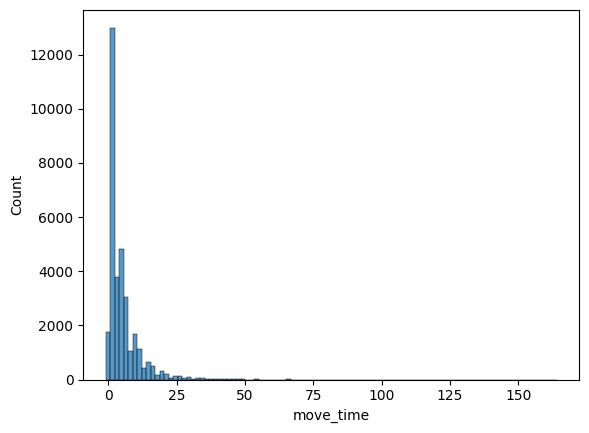

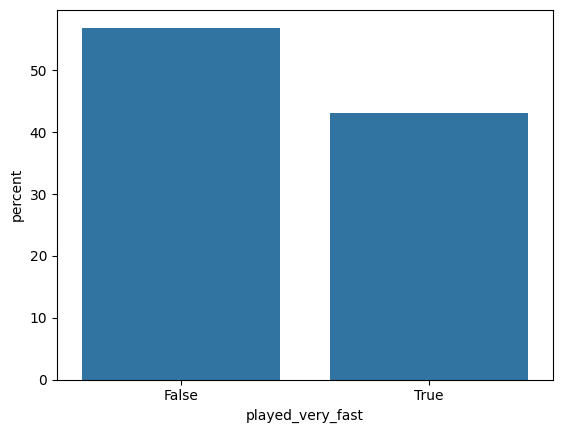

In [5]:
# histogram move_time
# use seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.histplot(games['move_time'], bins=100)

# bar chart with 2 groups
# first group: total count of moves played with less than 2 seconds
# second group: total count of moves played with more than 2 seconds
# use seaborn
plt.figure()
sns.countplot(x='played_very_fast',
              data=games,
              stat="percent")


A very sizable amount of moves (around 40% of all moves) are played very fast.

## Does the amount of time spent on a move determine its quality?

To answer the second question, whether the amount of time spent has any impact on the evaluations, we can display a scatterplot both for moves played very fast and slower moves.

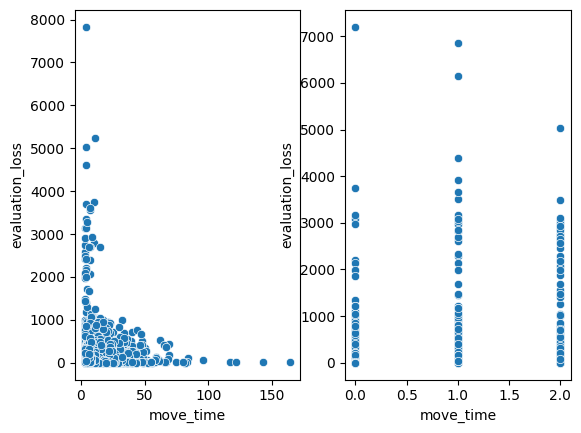

<Axes: xlabel='played_very_fast', ylabel='evaluation_loss'>

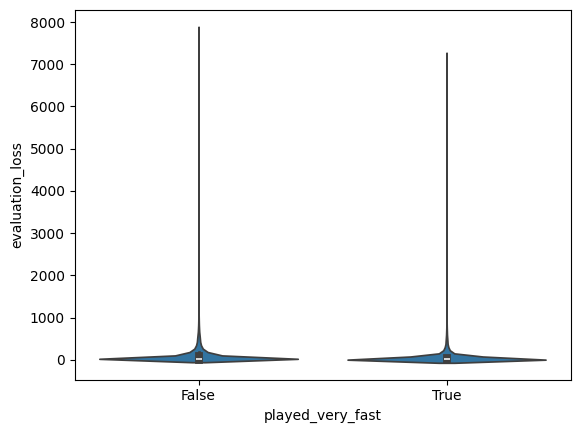

In [6]:
plt.figure()
plt.subplot(1, 2, 1)
sns.scatterplot(x='move_time',
                y='evaluation_loss',
                data=games[games['played_very_fast'] == False])

plt.subplot(1, 2, 2)
sns.scatterplot(x='move_time',
                y='evaluation_loss',
                data=games[games['played_very_fast'] == True])

plt.show()

plt.figure()
sns.violinplot(x='played_very_fast',
               y='evaluation_loss',
               data=games)


If we take 2 seconds as the threshold, the violin plots indicate there's not much of an evaluation difference between moves played very fast and those played a bit slower. However, on the scatterplot of moves played somewhat slower, we can see high evaluation loss values. Maybe if we slightly change the threshold of what constitutes a fast move from 2 seconds to 7 seconds (7 is what the scatterplot points at), we could see a difference.

<Axes: xlabel='played_very_fast', ylabel='evaluation_loss'>

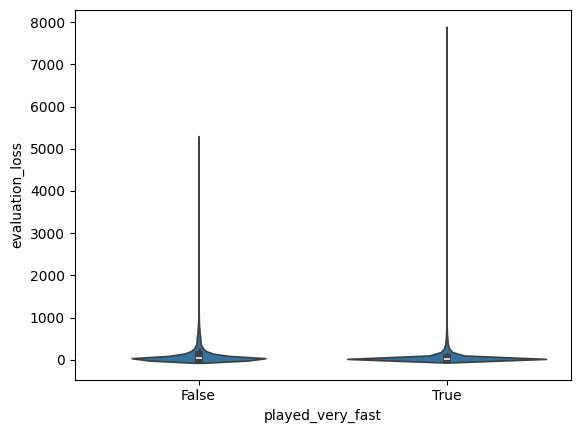

In [7]:
games['played_very_fast'] = games['move_time'] <= 7

plt.figure()
sns.violinplot(x='played_very_fast',
               y='evaluation_loss',
               data=games)

The picture is the same for most of the moves. However, now the outliers are different. The tail for moves played very fast is much longer than the one for moves played slower. We can filter out only those moves which would constitute a blunder (evaluation loss of 200 centipawns or more) and recreate the count plot we made before. If the ratio between moves played slower/moves played fast differs from the general population of 60/40, this would mean the move speed has an impact.

<Axes: xlabel='played_very_fast', ylabel='percent'>

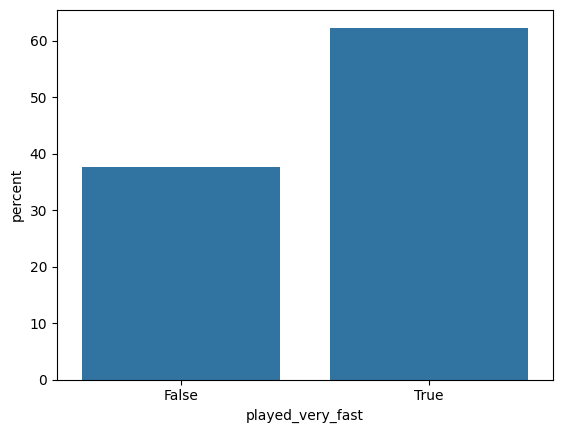

In [8]:
plt.figure()
sns.countplot(x='played_very_fast',
              data=games[games['evaluation_loss'] > 200],
              stat="percent")


The ratio is now inverted. Moves played very fast account for a disproportionate percentage of blunders. This solves our original question. 

## Conclusion

There's potential to look into this link between move times and evaluation more deeply. When do I play too fast? In what stage of the game? In what type of position. A more hybrid approach with selecting first the relevant positions and qualitatively analyzing them later on could pay off.

In terms of concrete changes based on this analysis, it makes me think there's a lot of improvement possible if I take a minimum of seconds for each move. A blitz game takes 300 seconds. Say an average game takes 60 moves. The first 10 moves are opening moves and can be blitzed out at almost no time cost. This makes 300 seconds for 50 moves. I can take 6 seconds per move and still make it. This is using the clock as a weapon.

Is my hunch of 60 moves by game correct though?

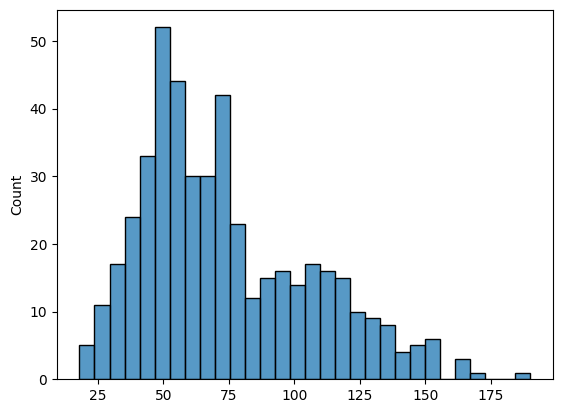

In [9]:
# count the number of moves per game
moves_per_game = games.groupby('game_id').size()

# histogram moves per game
sns.histplot(moves_per_game, bins=30)
plt.show()

I really underestimated the number of games more than 60 moves. Though I think the strategy should still work. If you ace the first 30/40 moves, most probably your opponent already made a mistake by then. The rest of the time could be spent on just killing  the game. Just resist the temptation of moving right away without doing a safety check.

In [10]:
# save games with extra calculated columns to file as games-enriched.csv
games.to_csv('games-enriched.csv', index=False)